# Bay Area Rapid Transit (BART) Delays During Peak Hours

## Brian Perea (2017)

## The Data Set:

Data characterized in this repository was collected from the BART and 
Open Weather Map APIs over the course of about a year from March 2016 to 
March 2017. Data points were collected seven days a week, twice a day -- 
once in the morning at 8 AM and once in the evening at 5 PM. These hours 
were selected to correspond to peak use hours, especially on weekdays.

The following features were collected:
* **date**: mm/dd/yyyy, date on which data was collected
* **description**: string, description of BART system status 
* **elev_status**: string, description of elevator status in BART system
* **posted**: string, timestamp associated with API call
* **traincount**: count, number of active trains
* **type**: string, "DELAY" when delays on BART, else NaN
* **weather**: string, one-word description of weather conditions

### Import Libraries and Configure Plotting

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re
import time

sns.set(style="ticks", context="notebook", font_scale=1.5)
sns.set_palette("muted", 3, .75, color_codes=True)
%matplotlib inline

### Load Data

In [2]:
df = pd.DataFrame.from_csv(r"./BART_data.csv", index_col=None)
df.head()

,date,description,elev_status,posted,time,traincount,type,weather
0,03/22/2016,There is a 10-minute delay on the Pittsburg/Ba...,There are two elevators out of service at this...,Tue Mar 22 2016 03:00 PM PDT,17:31:00 PM PDT,58.0,DELAY,Clear
1,03/23/2016,There is a 10-minute delay on the Pittsburg/Ba...,There are two elevators out of service at this...,Tue Mar 22 2016 03:00 PM PDT,08:00:00 AM PDT,59.0,DELAY,Clouds
2,03/23/2016,BART is running shuttle trains between North C...,There are two elevators out of service at this...,Wed Mar 23 2016 05:04 PM PDT,18:01:00 PM PDT,61.0,DELAY,Haze
3,03/24/2016,BART is running shuttle trains between North C...,There are two elevators out of service at this...,Wed Mar 23 2016 05:04 PM PDT,08:00:00 AM PDT,59.0,DELAY,Clouds
4,03/24/2016,BART is running shuttle trains between North C...,There are two elevators out of service at this...,Wed Mar 23 2016 05:04 PM PDT,17:30:00 PM PDT,60.0,DELAY,Clouds


### Let's start by looking at delays. How many delays were observed over the duration of data collection?

In [3]:
total_delays = np.sum(df["type"] == "DELAY")
total_timepoints = len(df)
percent_delayed = round(total_delays/total_timepoints * 100, 1)
start_date = df["date"][0]
end_date = df["date"].values[-1]

print("BART riders experienced delays on {total_delays} out of {total_timepoints} timepoints assessed (two per day).".format(total_delays=total_delays, total_timepoints=total_timepoints))
print("The BART system recorded a delay rate of {percent_delayed}% during peak hours (8 AM and 5 PM daily) between {start_date} and {end_date}.".format(percent_delayed=percent_delayed, 
    start_date=start_date, end_date=end_date))

BART riders experienced delays on 182 out of 436 timepoints assessed (two per day).
The BART system recorded a delay rate of 41.7% during peak hours (8 AM and 5 PM daily) between 03/22/2016 and 03/10/2017.


### Why were there so many delays? What kind of descriptions are provided?

In [4]:
df.sample(15).description

350                                  No delays reported.
351                                  No delays reported.
69                                   No delays reported.
432    Downtown Berkeley station has re-opened.  All ...
135                                  No delays reported.
121                                  No delays reported.
162                                  No delays reported.
60     BART is recovering from an earlier problem. Th...
22     Normal train service has resumed between North...
233                                  No delays reported.
349                                  No delays reported.
384    During this Holiday Season, BART will be runni...
35     Attention Passengers: This weekend there will ...
337                                  No delays reported.
201                                  No delays reported.
Name: description, dtype: object

### It looks like there are many days where `type` reports `DELAY` but `description` shows "`No delays reported.`" How many of these delays provide a delay duration estimate in the description?

In [5]:
for idx, data in df.iterrows():
    match = re.search("(\d{2})-minute delay", data["description"])
    if match:
        df.set_value(index=idx, col="delay_duration", value=int(match.group(1)))
    else:
        df.set_value(index=idx, col="delay_duration", value=0)

df.sample(5)

,date,description,elev_status,posted,time,traincount,type,weather,delay_duration
65,04/26/2016,No delays reported.,There is one elevator out of service at this t...,NaN,08:00:00 AM PDT,58.0,NaN,Mist,0.0
57,04/22/2016,There is a 10-minute delay at MacArthur in the...,There are two elevators out of service at this...,Fri Apr 22 2016 07:58 AM PDT,07:59:00 AM PDT,60.0,DELAY,Rain,10.0
224,07/19/2016,No delays reported.,There are three elevators out of service at th...,NaN,08:00:00 AM PDT,58.0,NaN,Clear,0.0
413,01/23/2017,BART is recovering from an earlier problem. Th...,There are three elevators out of service at th...,Mon Jan 23 2017 07:40 AM PST,07:59:00 AM PST,61.0,DELAY,Rain,10.0
323,09/12/2016,BART is recovering from an earlier problem. Th...,There are three elevators out of service at th...,Mon Sep 12 2016 04:52 PM PDT,17:30:00 PM PDT,59.0,DELAY,Mist,10.0


In [6]:
duration_provided = np.sum((df.delay_duration > 0) & (df.type == "DELAY"))
percent_without_duration = round((duration_provided)/total_delays * 100, 1)

print("{duration_provided} out of {total_delays} total delays provided delay duration estimates.".format(duration_provided=duration_provided, total_delays=total_delays))
print("{percent_without_duration}% of delays provided duration estimates.".format(percent_without_duration=percent_without_duration))

76 out of 182 total delays provided delay duration estimates.
41.8% of delays provided duration estimates.


### If the above is correct, then less than half of the reported delays in column `type` report any delay duration estimates. Can we identify true delays by identifying the word "delay" (and not "delays") in the description?

In [7]:
for idx, data in df.iterrows():
    match = re.search("delay ", data["description"]) # the space in "delay " is important
    if match:
        df.set_value(index=idx, col="desc_delay", value=True)
    else:
        df.set_value(index=idx, col="desc_delay", value=False)

df[["date", "description", "delay_duration", "desc_delay", "type"]].sample(5)

,date,description,delay_duration,desc_delay,type
417,01/31/2017,There is a 10-minute delay at San Francisco st...,10.0,True,DELAY
136,06/03/2016,No delays reported.,0.0,False,NaN
102,05/16/2016,No delays reported.,0.0,False,NaN
298,08/29/2016,No delays reported.,0.0,False,NaN
350,09/28/2016,No delays reported.,0.0,False,NaN


In [8]:
true_delays = np.sum((df.desc_delay == True) & (df.type == "DELAY"))
percent_false_delays = round((true_delays)/total_delays * 100, 1)

print("{true_delays} out of {total_delays} total delays were described as being delays.".format(true_delays=true_delays, total_delays=total_delays))
print("{percent_false_delays}% of postings classified as 'DELAYS' had 'delay' in the description.".format(percent_false_delays=percent_false_delays))

85 out of 182 total delays were described as being delays.
46.7% of postings classified as 'DELAYS' had 'delay' in the description.


In [9]:
duration_provided_true = np.sum((df.desc_delay == True) & (df.delay_duration > 0) & (df.type == "DELAY"))
percent_true_without_duration = round((duration_provided_true)/true_delays * 100, 1)

print("{duration_provided_true} out of {true_delays} total verified delays provided delay duration estimates.".format(duration_provided_true=duration_provided_true, true_delays=true_delays))
print("{percent_true_without_duration}% of verified delays provided duration estimates.".format(percent_true_without_duration=percent_true_without_duration))

75 out of 85 total verified delays provided delay duration estimates.
88.2% of verified delays provided duration estimates.


In [10]:
# How long is average delay duration?
mean_delay = df.loc[(df["type"] == "DELAY") & (df["desc_delay"] == True), "delay_duration"].mean()
print("Mean duration of delays is", round(mean_delay), "minutes.")

Mean duration of delays is 10 minutes.


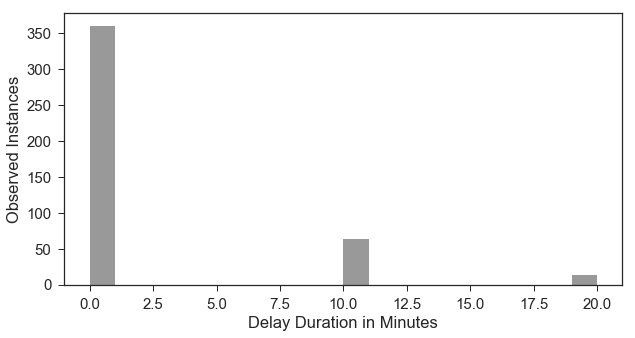

In [11]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.distplot(df["delay_duration"], kde=False, color="black", ax=ax)
ax.set(xlabel="Delay Duration in Minutes", ylabel="Observed Instances")
plt.show()

### Reporting of delays appears to be very general. Delays are reported as either 10 minutes or 20 minutes in duration. Is delay duration associated with weather conditions at all?

In [12]:
# Are longer delays associated with weather?
weather_delay = df.groupby(["weather", "delay_duration"]).size().reset_index()
weather_delay.rename(columns={0:"count"}, inplace=True)
weather_delay

,weather,delay_duration,count
0,Clear,0.0,84
1,Clear,10.0,9
2,Clear,20.0,3
3,Clouds,0.0,125
4,Clouds,10.0,14
5,Clouds,20.0,2
6,Drizzle,0.0,6
7,Fog,0.0,8
8,Fog,10.0,4
9,Haze,0.0,16


Duration of Observed Delays by Weather Condition for Timepoints Between 03/22/2016 and 03/10/2017


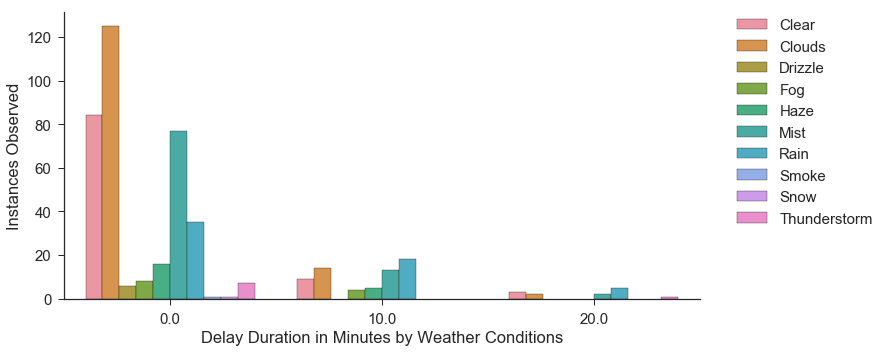

In [13]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

print("Duration of Observed Delays by Weather Condition for Timepoints Between {start_date} and {end_date}".format(start_date=start_date, end_date=end_date))

sns.barplot(x="delay_duration", y="count", hue="weather", data=weather_delay, ax=ax, ci=False, edgecolor="black")

ax.set(xlabel="Delay Duration in Minutes by Weather Conditions", ylabel="Instances Observed")

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
sns.despine(ax=ax)
plt.show()

### Rain is the only weather status that looks like it might be represented at higher levels during delays. This matches my expectations, since BART occasionally experiences delays due to wet conditions. Let's check this by looking at the representation of weather conditions by delay duration.

In [14]:
def convert_percentage(group):
    group_total = group["count"].sum()
    group["%count_by_weather"] = [x/group_total*100 for x in group["count"]]
    return(group)

weather_delay = weather_delay.groupby("delay_duration").apply(convert_percentage)
weather_delay

,weather,delay_duration,count,%count_by_weather
0,Clear,0.0,84,23.333333
1,Clear,10.0,9,14.285714
2,Clear,20.0,3,23.076923
3,Clouds,0.0,125,34.722222
4,Clouds,10.0,14,22.222222
5,Clouds,20.0,2,15.384615
6,Drizzle,0.0,6,1.666667
7,Fog,0.0,8,2.222222
8,Fog,10.0,4,6.349206
9,Haze,0.0,16,4.444444


Weather Conditions by Delay Duration for Timepoints Between 03/22/2016 and 03/10/2017


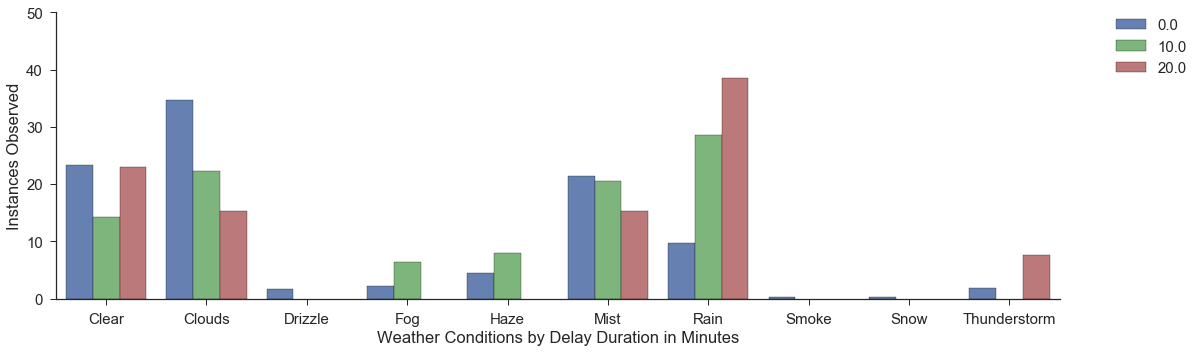

In [15]:
# Are longer delays associated with weather? Take 2.

fig, ax = plt.subplots(1, 1, figsize=(15, 5))

print("Weather Conditions by Delay Duration for Timepoints Between {start_date} and {end_date}".format(start_date=start_date, end_date=end_date))

sns.barplot(x="weather", y="%count_by_weather", hue="delay_duration", data=weather_delay, ax=ax, ci=False, edgecolor="black")

ax.set(xlabel="Weather Conditions by Delay Duration in Minutes", ylabel="Instances Observed", ylim=[0, 50])

plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
sns.despine(ax=ax)
plt.show()

### Indeed, longer delay durations appear to be overrepresented in rainy conditions. The thunderstorm data also hints at this. Thunderstorms are relatively rare in the Bay Area and I suspect they are associated with more severe storms and rain. If we had rainfall measurements for these timepoints, I suspect increased delays would correlate with increased rainfall.

### Anyone who has used the BART system has probably heard the system-wide announcements regarding the number of elevators out-of-service. Let's see what the data shows.

In [16]:
def count_elevators(status):
    """Return elevators out of service as integer value."""

    num_words = ["no", "one", "two", "three", "four", "five", "six", "seven", "eight", "nine", "ten", "eleven", "twelve"]
    text_to_int = dict(zip(num_words, range(12)))
    split = str.split(status, " ")

    for s in split:
        if s in num_words:
            return text_to_int[s]
    return 0
    
df["elev_count"] = df["elev_status"].apply(count_elevators)

Out of Service Elevators for Timepoints Between 03/22/2016 and 03/10/2017


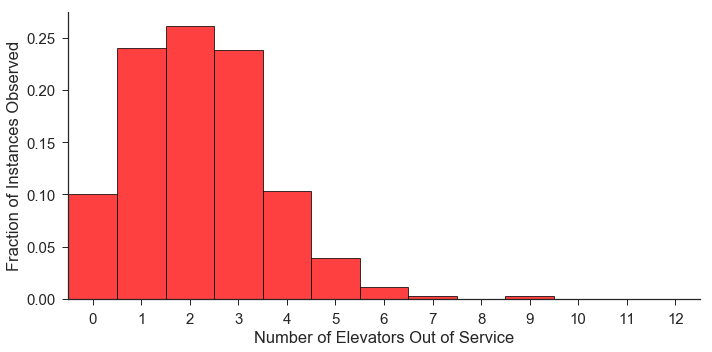

In [17]:
alpha = 0.75

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
print("Out of Service Elevators for Timepoints Between {start_date} and {end_date}".format(start_date=start_date, end_date=end_date))
sns.distplot(df["elev_count"], ax=ax, kde=False, color="red", hist_kws=dict(alpha=alpha, edgecolor="black", linewidth=1), bins=[-0.5 + x for x in range(13)], norm_hist=True)
ax.set(xlabel="Number of Elevators Out of Service", ylabel="Fraction of Instances Observed", xlim=[-0.5, 12.5], xticks=range(13))
plt.tight_layout()
sns.despine(ax=ax)
plt.show()

In [18]:
total_elev_out = np.sum(df["elev_count"] > 0)
percent_elev_out = round(total_elev_out/total_timepoints * 100, 1)

print("BART riders experienced elevator outages on {total_elev_out} out of {total_timepoints} timepoints assessed (two per day).".format(total_elev_out=total_elev_out, total_timepoints=total_timepoints))
print("The BART system recorded an elevator outage rate of {percent_elev_out}% during peak hours (8 AM and 5 PM daily) between {start_date} and {end_date}.".format(percent_elev_out=percent_elev_out, 
    start_date=start_date, end_date=end_date))

BART riders experienced elevator outages on 392 out of 436 timepoints assessed (two per day).
The BART system recorded an elevator outage rate of 89.9% during peak hours (8 AM and 5 PM daily) between 03/22/2016 and 03/10/2017.


### BART had elevators out-of-service about 90% of the time. From experience I know that the elevators out-of-service are usually not the same from day-to-day. It would be interesting to look at the frequency of particular station elevators going out of service. The results from that might suggest which station elevators need the most attention.

### Let's take a look at the number of active trains.

In [19]:
no_trains = df[np.logical_not(np.isfinite(df.traincount))].copy()
for idx, data in no_trains.iterrows():
    print('On {date} there were no trains listed due to the following status update:\n"{description}"'.format(date=data.date, description=data.description))

On 08/21/2016 there were no trains listed due to the following status update:
"There is no Bart service thru Daly City, Balboa Park or Glen Park stations this weekend August 20-21. There is a bus bridge between those stations. Expect up to 60 minute delays due to track maintenance. Visit Bart.gov for more info. "


### There were special circumstances in August due to track repairs. These circumstances resulted in some unreported values in the `traincount` data.


NaN values in column 'traincount' have been filled with 0.
Number of Active Trains for Timepoints Between 03/22/2016 and 03/10/2017


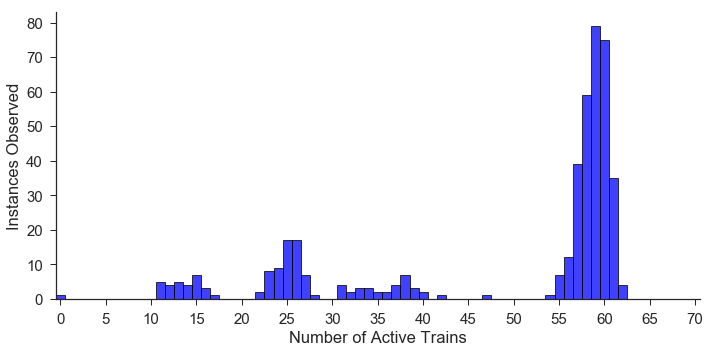

In [20]:
df.loc[no_trains.index, "traincount"] = 0
print("\nNaN values in column 'traincount' have been filled with 0.")

alpha = 0.75

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
print("Number of Active Trains for Timepoints Between {start_date} and {end_date}".format(start_date=start_date, end_date=end_date))
sns.distplot(df["traincount"], ax=ax, kde=False, color="blue", hist_kws=dict(alpha=alpha, edgecolor="black", linewidth=1), bins=[-0.5 + x for x in range(80)])
ax.set(xlabel="Number of Active Trains", ylabel="Instances Observed", xlim=[-0.5, 70.5], xticks=range(0, 80, 5))
plt.tight_layout()
sns.despine(ax=ax)
plt.show()

### It looks line the number of active trains is composed of multiple distinct distributions. Can the distributions in train count be attributed to day of the week (weekend vs weekday) and holidays?

In [21]:
# Let's start by parsing dates to yield days of the week

print(start_date, 'was a Tuesday.')
print("Parser gives day as:", time.strftime("%A", time.strptime(start_date, "%m/%d/%Y")))

03/22/2016 was a Tuesday.
Parser gives day as: Tuesday


In [22]:
def date_to_day(date_string):
    """Converts a date string into the day of the week."""
    return time.strftime("%A", time.strptime(date_string, "%m/%d/%Y"))

df["day"] = df["date"].apply(date_to_day)

Number of Active Trains for Timepoints Between 03/22/2016 and 03/10/2017


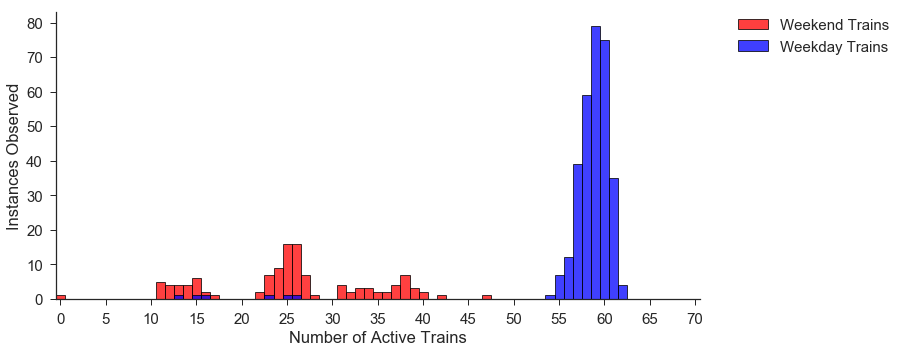

In [23]:
# Regenerate histogram by plotting weekday and weekend histograms on the same axes in different colors
weekday = df.loc[(df["day"] != "Saturday") & (df["day"] != "Sunday"), :].copy()
weekend = df.loc[(df["day"] == "Saturday") | (df["day"] == "Sunday"), :].copy()
df.loc[weekday.index, "weekday"] = True
df.loc[weekend.index, "weekday"] = False

alpha = 0.75
hist_kws = dict(alpha=alpha, edgecolor="black", linewidth=1)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))
bins = [-0.5 + x for x in range(80)]
print("Number of Active Trains for Timepoints Between {start_date} and {end_date}".format(start_date=start_date, end_date=end_date))
sns.distplot(weekend["traincount"], ax=ax, kde=False, bins=bins, hist_kws=hist_kws, label="Weekend Trains", color="red")
sns.distplot(weekday["traincount"], ax=ax, kde=False, bins=bins, hist_kws=hist_kws, label="Weekday Trains", color="blue")
ax.set(xlabel="Number of Active Trains", ylabel="Instances Observed", xlim=[-0.5, 70.5], xticks=range(0, 80, 5))
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
sns.despine(ax=ax)
plt.show()

### Clearly there are separate distributions for weekday and weekend train counts. The weekend `traincount` looks like it may also be made up of three distinct distributions. I suspect these correspond to combinations of day (Sat vs Sun) and time (morning vs evening). 

### There also appears to be a few outliers in the weekday data. I suspect the weekdays with `traincount` < 50 are holidays. Is this true?

In [24]:
# Are the few weekdays with a lower than average number of active trains holidays?
weekday.loc[(weekday["traincount"] < 50), "date"].drop_duplicates()

129    05/30/2016
195    07/04/2016
310    09/05/2016
Name: date, dtype: object

### Yes, all three dates are holidays.
* 05/30/2016 - Memorial Day
* 07/04/2016 - Independence Day
* 09/05/2016 - Labor Day

### Is there any association between the number of active trains and the weather conditions?

Number of Active Trains by Weather Condition for Timepoints Between 03/22/2016 and 03/10/2017


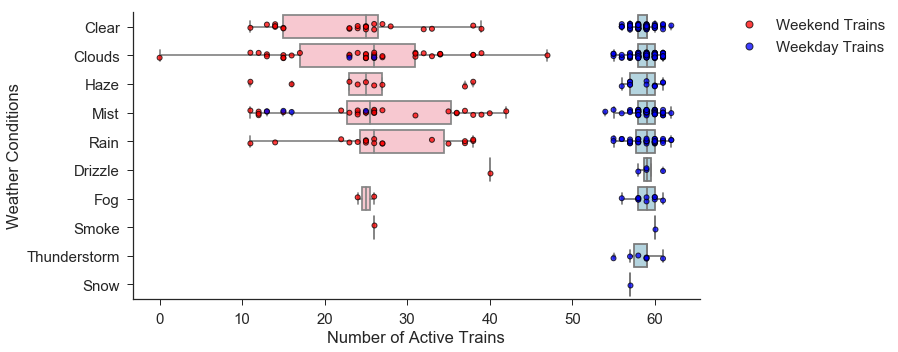

In [25]:
# How does weather relate to the number of active trains?
conditions = np.unique(df.weather)

fig, ax = plt.subplots(1, 1, figsize=(10, 5))

alpha = 0.75

print("Number of Active Trains by Weather Condition for Timepoints Between {start_date} and {end_date}".format(start_date=start_date, end_date=end_date))

sns.stripplot(x="traincount", y="weather", orient="h", data=weekend, ax=ax, jitter=True, color="red", edgecolor='black', linewidth=1, alpha=alpha)
sns.boxplot(x="traincount", y="weather", orient="h", data=weekend, ax=ax, color="pink")

sns.stripplot(x="traincount", y="weather", orient="h", data=weekday, ax=ax, jitter=True, color="blue", edgecolor='black', linewidth=1, alpha=alpha)
sns.boxplot(x="traincount", y="weather", orient="h", data=weekday, ax=ax, color="lightblue")

ax.set(xlabel="Number of Active Trains", ylabel="Weather Conditions")

weekend_legend = plt.Line2D((0,1),(0,0), color='red', marker='o', linestyle='', markeredgecolor="black", markeredgewidth=1, alpha=alpha)
weekday_legend = plt.Line2D((0,1),(0,0), color='blue', marker='o', linestyle='', markeredgecolor="black", markeredgewidth=1, alpha=alpha)

plt.legend([weekend_legend, weekday_legend], ["Weekend Trains", "Weekday Trains"], bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.tight_layout()
sns.despine(ax=ax)
plt.show()

### There does not appear to be any association between train count and weather conditions. The median values for the number of active trains are similar across weather conditions.

# That's all for now. Thanks for following along!

---
Brian Perea (c) 2017 - Find me on Github at https://github.com/bcperea